# Workflow - Gabbar

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

In [4]:
from sklearn.externals import joblib

## 1. Download labelled features from S3

In [5]:
changesets = pd.read_csv('https://s3-us-west-2.amazonaws.com/mapbox-gabbar/public/labelled_features.csv')

print('Shape of labelled changesets: {}'.format(changesets.shape))
changesets.head()

Shape of labelled changesets: (22335, 57)


,changeset_id,harmful,features_created,features_modified,features_deleted,user_id,user_name,user_first_edit,user_changesets,user_features,...,office,place,power,public_transport,railway,route,shop,sport,tourism,waterway
0,47898235,False,2,8,1,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,1,0,0
1,47898190,False,1,1,1,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,0,0,0
2,47898172,False,0,1,1,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,0,0,0
3,47898150,False,0,1,1,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,0,0,0
4,47898121,False,1,1,4,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
harmful_changesets = changesets[changesets['harmful'] == True]
print('Changesets harmful: {}'.format(harmful_changesets.shape[0]))

not_harmful_changesets = changesets[changesets['harmful'] == False]
print('Changesets not harmful: {}'.format(not_harmful_changesets.shape[0]))

Changesets harmful: 1654
Changesets not harmful: 20681


In [7]:
non_training_features = np.array(['changeset_id', 'harmful', 'user_first_edit', 'user_id', 'user_name', 'changeset_editor'])

features = changesets.columns.values
features = np.setdiff1d(features, non_training_features)

print('Total features: {}\n'.format(len(features)))
print('*** Feature list *** \n{}'.format('\n'.join(features)))

Total features: 51

*** Feature list *** 
aerialway
aeroway
amenity
barrier
bbox_area
boundary
building
changeset_editor_JOSM
changeset_editor_MAPS.ME
changeset_editor_Merkaartor
changeset_editor_OsmAnd
changeset_editor_Potlatch
changeset_editor_Redaction bot
changeset_editor_Vespucci
changeset_editor_gnome
changeset_editor_iD
changeset_editor_other
craft
emergency
feature_version_high
feature_version_low
feature_version_medium
feature_version_new
features_created
features_deleted
features_modified
geological
geometry_modifications
highway
historic
landuse
leisure
man_made
military
natural
node_count
office
place
power
property_modifications
public_transport
railway
relation_count
route
shop
sport
tourism
user_changesets
user_features
waterway
way_count


In [8]:
print('Changesets before dropping rows with null values: {}'.format(changesets[features].shape[0]))

# Drop entire row is any of the feature is null.
changesets = changesets.dropna(subset=features)

print('Changesets after dropping rows with null values: {}'.format(changesets[features].shape[0]))
changesets.head()

Changesets before dropping rows with null values: 22335
Changesets after dropping rows with null values: 21338


,changeset_id,harmful,features_created,features_modified,features_deleted,user_id,user_name,user_first_edit,user_changesets,user_features,...,office,place,power,public_transport,railway,route,shop,sport,tourism,waterway
0,47898235,False,2,8,1,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,1,0,0
1,47898190,False,1,1,1,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,0,0,0
2,47898172,False,0,1,1,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,0,0,0
3,47898150,False,0,1,1,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,0,0,0
4,47898121,False,1,1,4,109705.0,gscholz,2009-03-24T20:52:47.000Z,22272.0,1623482.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Target array.
y = changesets['harmful']

# Feature matrix.
X = changesets[features]
X.describe()

,aerialway,aeroway,amenity,barrier,bbox_area,boundary,building,changeset_editor_JOSM,changeset_editor_MAPS.ME,changeset_editor_Merkaartor,...,railway,relation_count,route,shop,sport,tourism,user_changesets,user_features,waterway,way_count
count,21338.000000,21338.000000,21338.000000,21338.000000,2.133800e+04,21338.000000,21338.000000,21338.000000,21338.000000,21338.000000,...,21338.000000,21338.000000,21338.000000,21338.000000,21338.000000,21338.000000,21338.000000,2.133800e+04,21338.000000,21338.000000
mean,0.000234,0.046162,0.763849,0.160324,6.495032e+11,0.563127,4.611210,0.281563,0.085997,0.000375,...,0.346424,1.325101,0.151467,0.364092,0.103899,0.114912,5804.140875,6.133879e+05,0.260568,12.286719
std,0.018111,1.322943,5.832073,1.418028,5.901853e+12,32.523533,75.609285,0.449772,0.280366,0.019360,...,20.934890,34.221603,1.150128,14.104479,0.854637,1.747101,16312.887361,2.730656e+06,5.180173,103.993830
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.537697e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,1.760000e+02,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,2.577437e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,448.500000,1.017900e+04,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,8.122828e+05,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3582.000000,2.722590e+05,0.000000,6.000000
max,2.000000,141.000000,536.000000,62.000000,2.137458e+14,4553.000000,8472.000000,1.000000,1.000000,1.000000,...,2950.000000,4550.000000,42.000000,2021.000000,33.000000,213.000000,280990.000000,3.139471e+07,511.000000,10001.000000


## 2. Normalize features for machine learning

In [10]:
# Scale features using RobustScaler which is good for outliers.
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(X)
X = scaler.transform(X)
print(scaler)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)


In [11]:
# Dump scaler to a file.
scalerpath = '../gabbar/trained/scaler.pkl'
joblib.dump(scaler, scalerpath, compress=3)

['../gabbar/trained/scaler.pkl']

## 3. Break up training and testing datasets

In [12]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, train_size=0.7)
print('Training samples: {}'.format(Xtrain.shape[0]))
print('Testing samples: {}'.format(Xtest.shape[0]))

Training samples: 14936
Testing samples: 6402


/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 4. Train model on training dataset

In [13]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'kernel': ['rbf'],
    'C': [1000, 10000],
    'probability': [True, False],
    'cache_size': [800],
    'gamma': ['auto'],
    'class_weight': ['balanced']
}

from sklearn.svm import SVC
grid = GridSearchCV(SVC(), parameters)
print('GridSearchCV with parameters: {}'.format(grid))

GridSearchCV with parameters: GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'probability': [True, False], 'C': [1000, 10000], 'gamma': ['auto'], 'cache_size': [800], 'kernel': ['rbf'], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)


In [14]:
# Fit the model at each grid point, keeping track of the scores along the way.
grid.fit(Xtrain, ytrain);

# Ask for the best parameters as follows
print('Best model parameters: {}'.format(grid.best_params_))

Best model parameters: {'probability': True, 'C': 10000, 'gamma': 'auto', 'cache_size': 800, 'class_weight': 'balanced', 'kernel': 'rbf'}


In [15]:
# Using the best model.
model = grid.best_estimator_
%time model.fit(Xtrain, ytrain)
print('Trained model: {}'.format(model))

CPU times: user 5min 1s, sys: 1.32 s, total: 5min 2s
Wall time: 5min 6s
Trained model: SVC(C=10000, cache_size=800, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [16]:
# Dump scaler to a file.
modelpath = '../gabbar/trained/model.pkl'
joblib.dump(model, modelpath, compress=3)

['../gabbar/trained/model.pkl']

## 5. Test model on testing dataset

In [17]:
ymodel = model.predict(Xtest)

## 6. Print performance metrics

In [18]:
changesets['prediction'] = model.predict(scaler.transform(changesets[features]))

print('Predicted harmful: {}'.format(changesets[changesets['prediction'] == True].shape[0]))
print('Predicted not harmful: {}'.format(changesets[changesets['prediction'] == False].shape[0]))

Predicted harmful: 3165
Predicted not harmful: 18173


In [19]:
changesets[(changesets['prediction'] == False) & (changesets['harmful'] == True)].head()

,changeset_id,harmful,features_created,features_modified,features_deleted,user_id,user_name,user_first_edit,user_changesets,user_features,...,place,power,public_transport,railway,route,shop,sport,tourism,waterway,prediction
6,47897677,True,6,14,6,4803528.0,Eva Blue,2016-11-03T12:16:03.000Z,16301.0,193329.0,...,1,0,0,0,0,0,0,0,0,False
30,47887966,True,7,2,0,1234040.0,HWaii,2017-04-17T23:01:55.000Z,23.0,373.0,...,0,0,0,0,0,0,0,0,0,False
38,47887243,True,15,5,0,5688393.0,AmmoniteDays,2017-04-17T22:43:20.000Z,3.0,32.0,...,0,0,0,0,0,0,0,0,1,False
41,47885714,True,96,9,0,5688041.0,Ryan Yantz,2017-04-17T21:17:12.000Z,1.0,105.0,...,0,0,0,0,0,0,0,0,0,False
44,47884771,True,5,2,0,5687631.0,Nattychamp,2017-04-17T20:11:25.000Z,6.0,102.0,...,0,0,0,0,0,0,0,0,0,False


In [20]:
booleans = [True, False]
columns = ['Labelled', 'Predicted', 'Number of changesets']
results = []
for actual in booleans:
    for prediction in booleans:
        temp = changesets[(changesets['harmful'] == actual) & (changesets['prediction'] == prediction)]
        results.append([actual, prediction, temp.shape[0]])
pd.DataFrame(results, columns=columns)

,Labelled,Predicted,Number of changesets
0,True,True,1201
1,True,False,248
2,False,True,1964
3,False,False,17925


In [21]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ymodel))

             precision    recall  f1-score   support

      False       0.96      0.88      0.92      5978
       True       0.24      0.51      0.32       424

avg / total       0.91      0.86      0.88      6402



In [22]:
# Evaluate a score by cross-validation.
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, cv=3)
np.mean(scores)

0.83826903016287879

/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


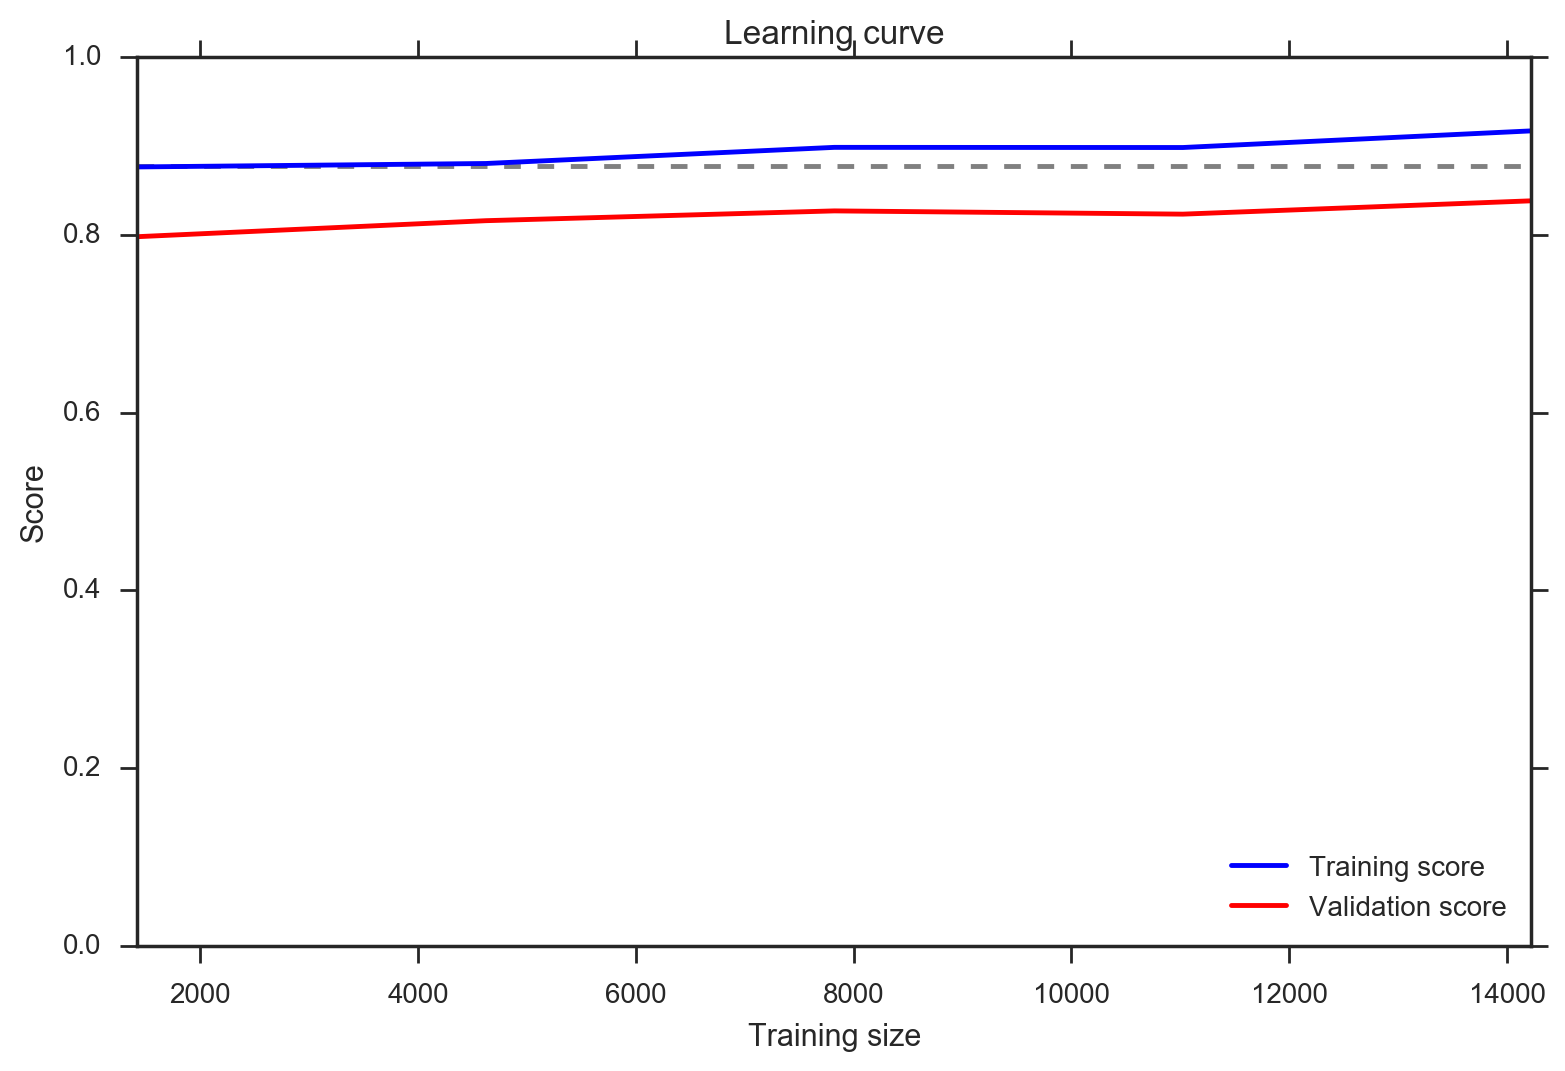

In [23]:
# Learning curve.
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 1)

N, train_lc, val_lc = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, 5))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='Training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='Validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')

ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('Training size')
ax.set_ylabel('Score')
ax.set_title('Learning curve')
ax.legend(loc='lower right')

plt.tight_layout()

## 7. Download unlabelled features from s3

In [24]:
changesets = pd.read_csv('https://s3-us-west-2.amazonaws.com/mapbox-gabbar/public/unlabelled_features.csv')

print('Shape of unlabelled changesets: {}'.format(changesets.shape))
changesets.head()

Shape of unlabelled changesets: (26190, 56)


,changeset_id,features_created,features_modified,features_deleted,user_id,user_name,user_first_edit,user_changesets,user_features,bbox_area,...,office,place,power,public_transport,railway,route,shop,sport,tourism,waterway
0,47370185,0,8,0,2285494.0,JJIglesias,2014-08-24T04:14:01.000Z,13386.0,657956.0,5.305908e+04,...,0,0,0,0,0,0,0,0,0,0
1,47370186,111,14,0,3735896.0,alexkemp,2016-03-21T22:36:44.000Z,1671.0,134797.0,3.115907e+05,...,0,0,0,0,0,0,0,0,0,1
2,47370184,316,165,89,74847.0,Marc Mongenet,2008-10-23T17:49:18.000Z,11919.0,2082970.0,6.223689e+06,...,0,0,0,0,0,0,0,0,0,0
3,47370182,0,1,0,5177123.0,Professor Cameron,2017-01-24T19:07:05.000Z,1347.0,11146.0,3.806499e+04,...,0,0,0,0,0,0,0,0,0,0
4,47370181,20,0,0,3593219.0,musawo,2016-02-04T13:35:05.000Z,1544.0,128109.0,2.451442e+04,...,0,0,0,0,0,0,0,0,0,0


In [25]:
print('Changesets before dropping rows with null values: {}'.format(changesets[features].shape[0]))

# Drop entire row is any of the feature is null.
changesets = changesets.dropna(subset=features)

print('Changesets after dropping rows with null values: {}'.format(changesets[features].shape[0]))
changesets.head()

Changesets before dropping rows with null values: 26190
Changesets after dropping rows with null values: 26075


,changeset_id,features_created,features_modified,features_deleted,user_id,user_name,user_first_edit,user_changesets,user_features,bbox_area,...,office,place,power,public_transport,railway,route,shop,sport,tourism,waterway
0,47370185,0,8,0,2285494.0,JJIglesias,2014-08-24T04:14:01.000Z,13386.0,657956.0,5.305908e+04,...,0,0,0,0,0,0,0,0,0,0
1,47370186,111,14,0,3735896.0,alexkemp,2016-03-21T22:36:44.000Z,1671.0,134797.0,3.115907e+05,...,0,0,0,0,0,0,0,0,0,1
2,47370184,316,165,89,74847.0,Marc Mongenet,2008-10-23T17:49:18.000Z,11919.0,2082970.0,6.223689e+06,...,0,0,0,0,0,0,0,0,0,0
3,47370182,0,1,0,5177123.0,Professor Cameron,2017-01-24T19:07:05.000Z,1347.0,11146.0,3.806499e+04,...,0,0,0,0,0,0,0,0,0,0
4,47370181,20,0,0,3593219.0,musawo,2016-02-04T13:35:05.000Z,1544.0,128109.0,2.451442e+04,...,0,0,0,0,0,0,0,0,0,0


## 8. Test model on unlabelled features dataset

In [26]:
# Load the scaler and model.
loaded_scaler = joblib.load(scalerpath)
loaded_model = joblib.load(modelpath)

changesets['prediction'] = loaded_model.predict(loaded_scaler.transform(changesets[features]))

## 9. Print performance metrics

In [27]:
print('Predicted harmful     : {}'.format(changesets[changesets['prediction'] == True].shape[0]))
print('Predicted not harmful : {}'.format(changesets[changesets['prediction'] == False].shape[0]))

Predicted harmful     : 1775
Predicted not harmful : 24300


In [28]:
changesets[changesets['prediction'] == True].head()

,changeset_id,features_created,features_modified,features_deleted,user_id,user_name,user_first_edit,user_changesets,user_features,bbox_area,...,place,power,public_transport,railway,route,shop,sport,tourism,waterway,prediction
9,47370173,1,0,0,4922121.0,znerol_ch,2016-12-04T10:57:34.000Z,21.0,34.0,0.0000,...,0,0,0,0,0,0,0,1,0,True
14,47370160,1,0,0,4922121.0,znerol_ch,2016-12-04T10:57:34.000Z,21.0,34.0,0.0000,...,0,0,0,0,0,0,0,1,0,True
29,47370158,0,1,0,5129797.0,The Inning Club,2017-04-01T16:11:31.000Z,5.0,63.0,515.4142,...,0,0,0,0,0,0,0,0,0,True
69,47370109,16,0,1,5586842.0,Carchiav,2017-03-30T19:39:58.000Z,71.0,3897.0,3242.0387,...,0,0,0,0,0,0,0,0,0,True
71,47370114,0,1,0,5599591.0,Rwy29L,2017-04-01T23:53:23.000Z,3.0,3.0,315.9669,...,0,0,0,0,0,0,0,0,0,True
